In [1]:
%%capture
import jax 
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt

try:
    from probml_utils import latexify, savefig, is_latexify_enabled
except ModuleNotFoundError:
    %pip install git+https://github.com/probml/probml-utils.git
    from probml_utils import latexify, savefig, is_latexify_enabled

jax.config.update("jax_enable_x64", True)

try:
    import tinygp
except ModuleNotFoundError:
    %pip install -qqq tinygp
    import tinygp

try:
    import jaxopt
except ModuleNotFoundError:
    %pip install jaxopt
    import jaxopt

from tinygp import GaussianProcess, kernels
import numpy as np
latexify(width_scale_factor=1, fig_height=2)
marksize = 10 if is_latexify_enabled() else 30

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/probml/probml-utils.git to /tmp/pip-req-build-82j40u85
  Running command git clone -q https://github.com/probml/probml-utils.git /tmp/pip-req-build-82j40u85
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 272 kB 11.3 MB/s 
     |████████████████████████████████| 125 kB 58.0 MB/s 
     |████████████████████████████████| 88 kB 9.6 MB/s 
     |████████████████████████████████| 72 kB 735 kB/s 
     |████████████████████████████████| 1.1 MB 52.0 MB/s 
  Created wheel for probml-utils: filename=probml_utils-0.1.dev76+g0b538d3-py3-none-any.whl size=101573 sha256=46244769d89b94b569a8b1f20d8d969a7214493ba188361f09e8af1e603706a9
  Stored in directory: /tmp/pip-ephem-wheel-cache-58dm6e6r/wheels/37/8f/cb/b845cd5de3d7f648717815f9c27bec49975bf58637a97fa6be
 

/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


In [2]:
class LinearKernel(tinygp.kernels.Kernel):
  def __init__(self,scale):
    self.scale = scale
  
  def evaluate(self,X1,X2):
    X1 = jnp.atleast_1d(X1)[..., None]
    X2 = jnp.atleast_1d(X2)[..., None]
    return self.scale*(jnp.sum(jnp.matmul((X1+1),(X2+1))))

class ConstantKernel(tinygp.kernels.Kernel):
  def __init__(self,scale):
    self.scale = scale
  
  def evaluate(self,X1,X2):
    X1 = jnp.atleast_1d(X1)[..., None]
    X2 = jnp.atleast_1d(X2)[..., None]
    return self.scale*jnp.sum(jnp.ones(jnp.shape(X1*X2)))

class PolyLinearKernel(tinygp.kernels.Kernel):
  def __init__(self,scale):
    self.scale = scale
  
  def evaluate(self,X1,X2):
    X1 = jnp.atleast_1d(X1)[..., None]
    X2 = jnp.atleast_1d(X2)[..., None]
    return self.scale*(jnp.sum(1+jnp.matmul(X1,X2)))

class WhiteNoiseKernel(tinygp.kernels.Kernel):
  def __init__(self,scale):
    self.scale = scale
  
  def evaluate(self,X1,X2):
    X1 = jnp.atleast_1d(X1)[..., None]
    X2 = jnp.atleast_1d(X2)[..., None]
    X3 = X1==X2
    X4 = jnp.zeros_like(X1)
    X4 = jnp.where(X3,1,X4)
    return self.scale*(jnp.sum(X4))


class QuadKernel(tinygp.kernels.Kernel):
  def __init__(self,scale):
    self.scale = scale
  
  def evaluate(self,X1,X2):
    X1 = jnp.atleast_1d(X1)[..., None]
    X2 = jnp.atleast_1d(X2)[..., None]
    return self.scale*(jnp.sum( (1+jnp.matmul(X1,X2)))**2)

  




<Figure size 432x288 with 0 Axes>

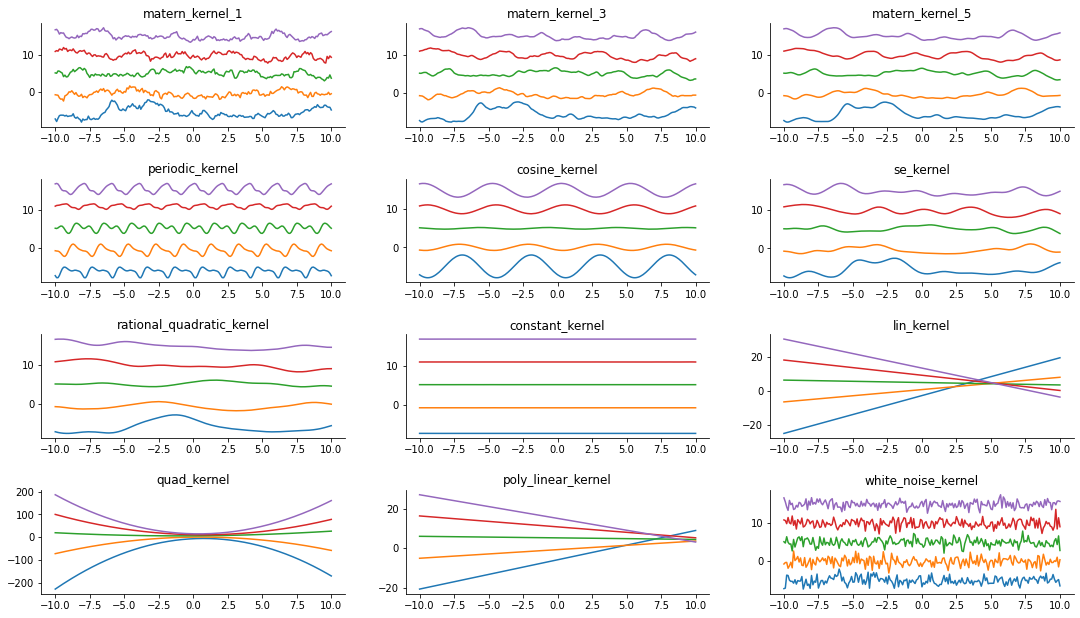

/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


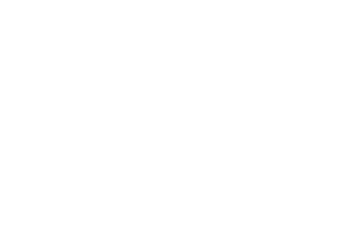

<Figure size 432x288 with 0 Axes>

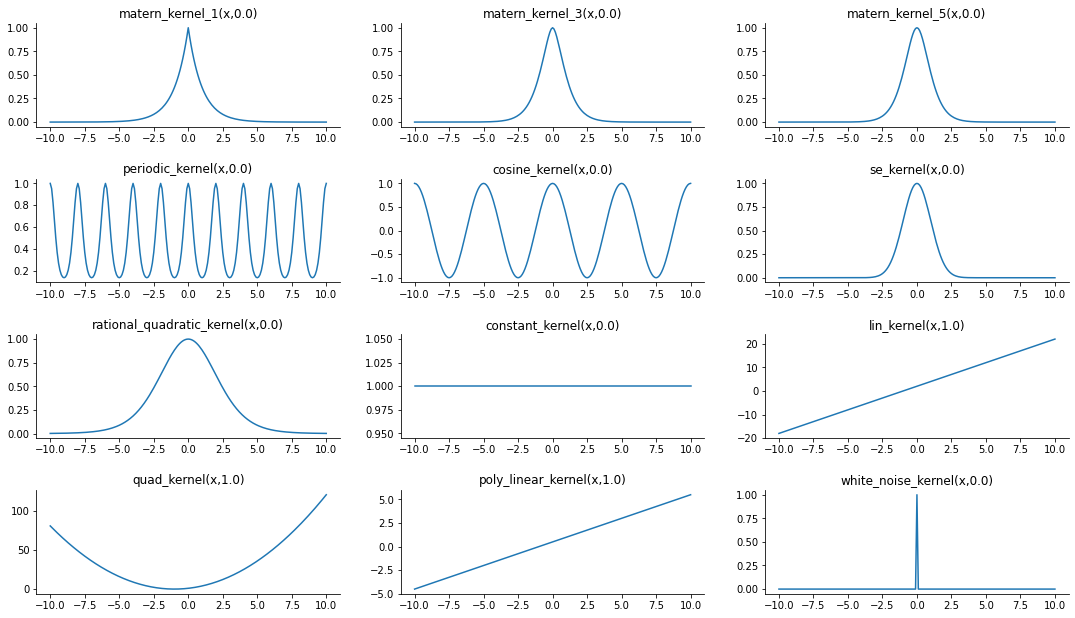

/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


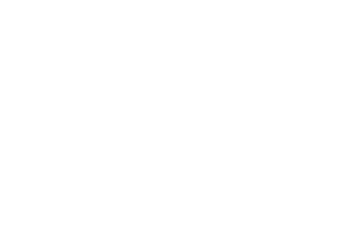

In [4]:
def gp_kernel_plot(seed):
  if(seed ==1):
    return
  n_xstar = 201
  num_examples = 5
  x_range = jnp.linspace(-10,10,n_xstar).reshape(-1,1)
  numerical_noise = 1e-5
  k = kernels.Matern52(scale=1.0)
  gp = GaussianProcess(k,x_range,diag=numerical_noise)
  no_grid_rows = 4
  no_grid_cols = 3


  se_kernel = kernels.ExpSquared(scale = 1.0)
  lin_kernel = LinearKernel(scale=1.0)
  quad_kernel = QuadKernel(scale=1.0)
  matern_kernel_1 = kernels.Exp(scale=1.0)
  matern_kernel_3 = kernels.Matern32(scale=1.0)
  matern_kernel_5 = kernels.Matern52(scale=1.0)
  periodic_kernel = kernels.ExpSineSquared(scale = 2.0,gamma=jnp.array(2.0))
  cosine_kernel = kernels.Cosine(scale=5.0)
  rational_quadratic_kernel = kernels.RationalQuadratic(scale=2,alpha=5)
  constant_kernel = ConstantKernel(scale=1)
  poly_linear_kernel = PolyLinearKernel(scale=0.5)
  white_noise_kernel = WhiteNoiseKernel(scale = 1)


  kernel_names = {
          "matern_kernel_1": (matern_kernel_1,0.0),
          "matern_kernel_3": (matern_kernel_3,0.0),
          "matern_kernel_5": (matern_kernel_5,0.0),
          "periodic_kernel": (periodic_kernel,0.0),
          "cosine_kernel": (cosine_kernel,0.0),
          "se_kernel":(se_kernel,0.0),
          "rational_quadratic_kernel":(rational_quadratic_kernel,0.0),
          "constant_kernel":(constant_kernel,0.0),
          "lin_kernel":(lin_kernel,1.0),
          "quad_kernel":(quad_kernel,1.0),
          "poly_linear_kernel":(poly_linear_kernel,1.0),
          "white_noise_kernel":(white_noise_kernel,0.0)

      }
  
  plt.figure()
  fig, axs = plt.subplots(nrows=no_grid_rows, ncols=no_grid_cols)
  fig.set_size_inches(18.5, 10.5)
  plt.subplots_adjust(hspace=0.5)
  for fig_no, (kernel_name,ax) in enumerate(zip(kernel_names,axs.ravel())):
    kernel = kernel_names[kernel_name][0]
    
    gp = GaussianProcess(kernel,x_range,diag=numerical_noise)
    samples = jnp.atleast_2d(gp.sample(jax.random.PRNGKey(0),shape = (num_examples,)).T)
    samples = samples + jnp.tile(jnp.arange(1, num_examples + 1, 1) * 5 - 10, (n_xstar, 1))
    ax.plot(x_range, samples)
    ax.set_title(kernel_name, fontsize=12)  
  sns.despine()
  plt.show()
  plt.axis("off")
  savefig("gpKernelSamples_latexified")

  plt.figure()
  fig, axs = plt.subplots(nrows=no_grid_rows, ncols=no_grid_cols)
  fig.set_size_inches(18.5, 10.5)
  plt.subplots_adjust(hspace=0.5)

  for fig_no, (kernel_name,ax) in enumerate(zip(kernel_names,axs.ravel())):
    kernel = kernel_names[kernel_name][0]
    X1 = jnp.array([[0.]]) if kernel_names[kernel_name][1]==0.0 else jnp.array([[1.]])
    ax.plot(x_range, kernel(x_range, X1))
    ax.set_title(f"{kernel_name}(x,{kernel_names[kernel_name][1]})", fontsize=12)
  sns.despine()
  plt.show()
  plt.axis("off")
  savefig("gpKernels_latexified")
gp_kernel_plot(2)

